# Chapter 4: Transfer Learning And Other Tricks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
transfer_model = models.resnet50(pretrained=True) 

D:\Software\Python Enviorments\pytorch_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Software\Python Enviorments\pytorch_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Freezing parameters

Batch normalization (often labeled as "bn" in parameters) normalizes input in neural networks. When you freeze network parameters, they don't update during training. Batch normalization layers should usually remain unfrozen to adapt to data statistics. Excluding parameters with "bn" in their names keeps these layers trainable, vital for model performance and convergence, while other layers like convolutional and fully connected ones can be frozen for fine-tuning.e.

In [3]:
# Freeze all model parameters except for batch normalization layers (bn)
for name, param in transfer_model.named_parameters():
    if("bn" not in name): # 
        param.requires_grad = False

## Replacing the classifier

In [4]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(500,2)) 

In [5]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [6]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
train_data_path = "../Chapter 2/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "../Chapter 2/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [7]:
print(len(val_data_loader.dataset))

102


In [8]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [9]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=5,
      device=device)

C:\Users\rsani\AppData\Local\Temp\ipykernel_12072\1650489001.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 0.57, Validation Loss: 0.29, accuracy = 0.88
Epoch: 2, Training Loss: 0.19, Validation Loss: 0.46, accuracy = 0.85
Epoch: 3, Training Loss: 0.10, Validation Loss: 0.43, accuracy = 0.85
Epoch: 4, Training Loss: 0.14, Validation Loss: 0.21, accuracy = 0.94
Epoch: 5, Training Loss: 0.03, Validation Loss: 0.23, accuracy = 0.93


## LR Finder

In [39]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    # Calculate the number of iterations in an epoch
    number_in_epoch = len(train_loader) - 1
    # Calculate the update step for learning rate
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    # Initialize the learning rate
    lr = init_value
    # Set the initial learning rate in the optimizer
    optimizer.param_groups[0]["lr"] = lr
    # Initialize variables to track the best loss, current batch number, and lists for losses and learning rates
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    # Loop through the data in the training loader
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Check for an exploding loss and return if necessary
        if batch_num > 1 and loss > 4 * best_loss:
            if len(log_lrs) > 20:
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the current loss and learning rate values
        losses.append(loss.item())
        log_lrs.append(lr)

        # Perform the backward pass and optimize the model
        loss.backward()
        optimizer.step()

        # Update the learning rate for the next step
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    # Return the learning rates and losses
    if len(log_lrs) > 20:
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

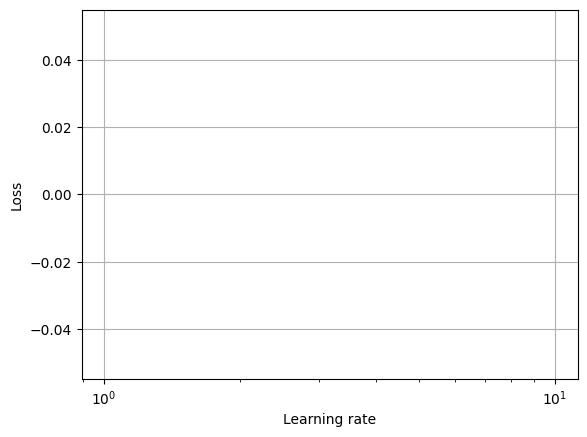

In [40]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Custom Transforms
Here we'll create a lambda transform and a custom transform class.

In [41]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output 

In [42]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

In [43]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

In [44]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

## Ensembles
Given a list of models, we can produce predictions for each model and then make an average to make a final prediction.

In [45]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

C:\Users\rsani\AppData\Local\Temp\ipykernel_12072\210517164.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble]


In [46]:
avg_prediction

tensor(23, device='cuda:0')

In [48]:
torch.stack(predictions)

tensor([[[0.0056, 0.0011, 0.0012,  ..., 0.0007, 0.0015, 0.0006]],

        [[0.0010, 0.0009, 0.0012,  ..., 0.0004, 0.0008, 0.0007]]],
       device='cuda:0', grad_fn=<StackBackward0>)